In [1]:
import numpy as np
import pandas as pd

# Step 1: Generate synthetic dataset
np.random.seed(42)
num_samples = 2000  # Number of samples

# Random temperature values in Celsius
temperatures_celsius = np.random.uniform(34.4, 40.0, size=num_samples)

# Assign categories based on temperature ranges in Celsius
categories = []
for temp in temperatures_celsius:
    if 36.5 <= temp <= 37.5:
        categories.append(0)  # Normal
    elif temp < 36.5:
        categories.append(1)  # Low Fever
    else:
        categories.append(2)  # High Fever

# Create a DataFrame
data = pd.DataFrame({'Temperature (°C)': temperatures_celsius, 'Category': categories})

# Save the dataset to a CSV file
data.to_csv('temperature_dataset.csv', index=False)

print("Dataset saved to 'temperature_dataset.csv'")


Dataset saved to 'temperature_dataset.csv'


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 2: Load dataset
data = pd.read_csv('temperature_dataset.csv')

# Preprocess the data
temperatures_celsius = data['Temperature (°C)'].values
categories = data['Category'].values

# Generate synthetic images based on temperatures
X = np.array([np.full((128, 128, 1), temp / 40.0) for temp in temperatures_celsius])  # Normalize by 40
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to RGB

y = np.array(categories)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data loaded and preprocessed.")


Data loaded and preprocessed.


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.5117 - loss: 1.0202 - val_accuracy: 0.8050 - val_loss: 0.7527
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.8244 - loss: 0.6814 - val_accuracy: 0.8050 - val_loss: 0.5946
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8256 - loss: 0.5517 - val_accuracy: 0.8050 - val_loss: 0.4846
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.8317 - loss: 0.4632 - val_accuracy: 0.8050 - val_loss: 0.4219
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.8506 - loss: 0.3885 - val_accuracy: 0.8525 - val_loss: 0.3800
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.8822 - loss: 0.3618 - val_accuracy: 0.8050 - val_loss: 0.3553
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9080 - loss: 0.3379 - val_accuracy: 0.8500 - val_loss: 0.3238
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9254 - loss: 0.2962 - val_accuracy: 0.9875

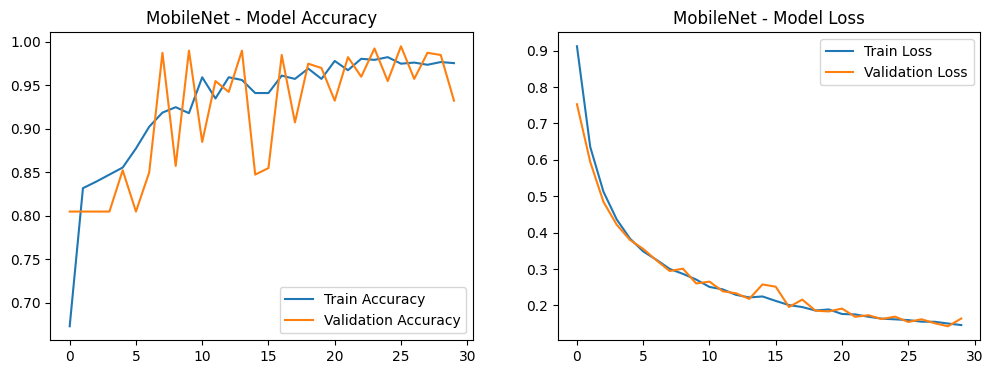

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

# Step 3: Build the MobileNetV2 model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation='softmax')  # 3 classes: Normal, Low Fever, High Fever
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=30,  # Adjust epochs based on training needs
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Save the trained model
model.save('temperature_model_mobilenet.h5')

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNet - Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNet - Model Loss')
plt.legend()

plt.show()


In [4]:
import numpy as np

# Step 5: Load the trained model
model = tf.keras.models.load_model('temperature_model_mobilenet.h5')

# Function to predict temperature category
def predict_temperature_category(temp_celsius):
    # Normalize the input temperature
    temp_normalized = temp_celsius / 40.0  # Normalize based on dataset range

    # Generate a dummy image
    X_input = np.full((128, 128, 1), temp_normalized)
    X_input_resized = np.repeat(X_input, 3, axis=-1)  # Convert to RGB
    X_input_resized = np.expand_dims(X_input_resized, axis=0)  # Add batch dimension

    # Predict the category
    predictions = model.predict(X_input_resized)
    predicted_class = np.argmax(predictions, axis=-1)[0]

    # Map the predicted class to its label
    class_labels = ['Normal', 'Low Fever', 'High Fever']
    predicted_label = class_labels[predicted_class]

    return predicted_label, predictions

# Test predictions
temps_to_test = [35.0, 36.5, 38.0, 39.5]
for temp in temps_to_test:
    predicted_label, probabilities = predict_temperature_category(temp)
    print(f"Temperature: {temp}°C -> Predicted: {predicted_label} (Probabilities: {probabilities})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
Temperature: 35.0°C -> Predicted: Low Fever (Probabilities: [[1.3235464e-02 9.8641032e-01 3.5423471e-04]])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Temperature: 36.5°C -> Predicted: Normal (Probabilities: [[0.501596   0.4684462  0.02995782]])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Temperature: 38.0°C -> Predicted: High Fever (Probabilities: [[0.14076036 0.00562954 0.8536101 ]])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Temperature: 39.5°C -> Predicted: High Fever (Probabilities: [[9.6780126e-04 1.3845249e-05 9.9901843e-01]])


In [33]:
import tensorflow as tf
import numpy as np

# Step 5: Load the trained model
model = tf.keras.models.load_model('temperature_model_mobilenet.h5')

# Function to predict temperature category
def predict_temperature_category(temp_celsius):
    # Normalize the input temperature
    temp_normalized = temp_celsius / 40.0  # Normalize based on dataset range

    # Generate a dummy image
    X_input = np.full((128, 128, 1), temp_normalized)
    X_input_resized = np.repeat(X_input, 3, axis=-1)  # Convert to RGB
    X_input_resized = np.expand_dims(X_input_resized, axis=0)  # Add batch dimension

    # Predict the category
    predictions = model.predict(X_input_resized)
    predicted_class = np.argmax(predictions, axis=-1)[0]

    # Map the predicted class to its label
    class_labels = ['Normal', 'Low Fever', 'High Fever']
    predicted_label = class_labels[predicted_class]

    return predicted_label, predictions

# Input temperature value
temp_celsius = float(input("Enter a temperature in °C: "))
predicted_label, probabilities = predict_temperature_category(temp_celsius)
print(f"Temperature: {temp_celsius}°C -> Predicted: {predicted_label} (Probabilities: {probabilities})")


Enter a temperature in °C:  36.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Temperature: 36.5°C -> Predicted: Normal (Probabilities: [[0.5137612  0.4653896  0.02084914]])


In [2]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('temperature_model_mobilenet.h5')


In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Load the dataset
data = pd.read_csv('temperature_dataset.csv')
temperatures_celsius = data['Temperature (°C)'].values
categories = data['Category'].values

# Generate synthetic images
X = np.array([np.full((128, 128, 1), temp / 40.0) for temp in temperatures_celsius])
X = np.repeat(X, 3, axis=-1)
y = np.array(categories)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Generate predictions for the test dataset
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class indices

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print metrics
print("Confusion Matrix:")
print(conf_matrix)

print("\n MobileNet - Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Normal', 'Low Fever', 'High Fever']))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step 
Confusion Matrix:
[[ 78   0   0]
 [  3 139   0]
 [  3   0 177]]

 MobileNet - Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      1.00      0.96        78
   Low Fever       1.00      0.98      0.99       142
  High Fever       1.00      0.98      0.99       180

    accuracy                           0.98       400
   macro avg       0.98      0.99      0.98       400
weighted avg       0.99      0.98      0.99       400

Precision: 0.9861
Recall: 0.9850
F1 Score: 0.9852


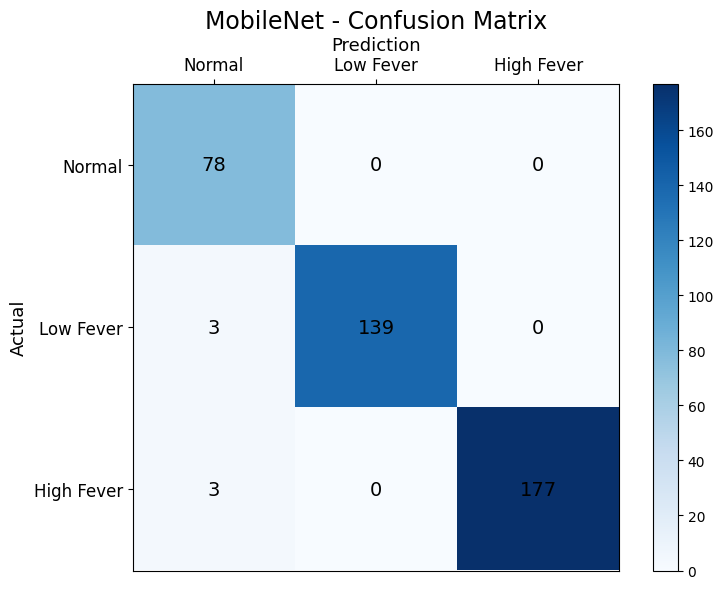

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Blues')  # Use the 'Blues' colormap
fig.colorbar(cax)

# Annotate the confusion matrix with the counts
for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=14)

# Set axis labels and ticks
ax.set_xticks(range(len(['Normal', 'Low Fever', 'High Fever'])))
ax.set_yticks(range(len(['Normal', 'Low Fever', 'High Fever'])))
ax.set_xticklabels(['Normal', 'Low Fever', 'High Fever'], fontsize=12)
ax.set_yticklabels(['Normal', 'Low Fever', 'High Fever'], fontsize=12)

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Set axis labels and title
ax.set_xlabel('Prediction', fontsize=13)
ax.set_ylabel('Actual', fontsize=13)
plt.title('MobileNet - Confusion Matrix', fontsize=17)

# Show the plot
plt.tight_layout()
plt.show()
